# Projeto 1 - Ciência dos Dados

- Pedro Fracasi
- Camila Bernardi
- Victor Assis

___
## Contextualização

League of Legends (LoL) é o maior jogo multiplayer da atualidade. Com mais de [115 milhões](https://leaguefeed.net/did-you-know-total-league-of-legends-player-count-updated/#:~:text=While%20Dota%202%20has%20around,has%201%20million%20daily%20players.) de jogadores ativos mensalmente, a comunidade está constantemente falando e opinando sobre o jogo no Twitter.
Assim, é de interesse corporativo o conhecimento em relação a porcentagem de engajamento relacionado a tag "lol" na plataforma Twitter que se refere ao jogo, tâo quanto as críticas geradas ao redor do jogo e de sua comunidade.

___
Primeiro, instalamos algumas bibliotecas auxiliares pra limpeza dos tweets

In [1]:
# Instalação do nltk e pacotes adicionais, usados pra stemming, lemmetization e stopwords.
!pip install nltk
!python -m nltk.downloader floresta
!python -m nltk.downloader stopwords
!python -m nltk.downloader rslp

# Instalação de algumas outras libs
!pip install emoji

/opt/conda/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package floresta to /home/jovyan/nltk_data...
[nltk_data]   Package floresta is already up-to-date!
/opt/conda/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/conda/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading 

___
Então importamos tudo

In [2]:
%matplotlib inline
import emoji
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [3]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/home/jovyan


Carregando a base de dados com os tweets classificados manualmente

In [4]:
filename = 'lol.xlsx'

In [5]:
train_bruto = pd.read_excel(filename)
train_bruto.head(5)

,Treinamento,Classificação
0,pq eu estou caindo com gente nivel 843 no lol,3.0
1,"meu deus a boneca nova do lol fala ""padrãozinh...",3.0
2,@pauloabf26 league of legends? smp fico perdid...,2.0
3,"muito divertido joga lol, matei a saudade daqu...",1.0
4,pensando na vez q fiquei 14 horas em chamada c...,2.0


In [6]:
test_bruto = pd.read_excel(filename, sheet_name = 'Teste')
test_bruto.head(5)

,Teste,Classificação
0,meu erro foi jogar lol,3.0
1,@cacpiao @louiswilliard ben feito kk lol,0.0
2,fazendo voz de loli hj pra ajudar o amiguinho ...,3.0
3,@cornetadaloud @fiaviohs ele falou que vsi ter...,2.0
4,----fim da busca por webnamoro no lol----,2.0


### Limpando os tweets

##### Para a limpeza dos tweets implementou-se técnicas de retirada de pontuações, separação de espaços, separação de emojis, menções a nomes de usuários e stemming.

In [7]:
stemmer = nltk.stem.RSLPStemmer()

def limpeza (text):
    # Remover marcações de usuários e alguns sinais de pontuação
    pattern = re.compile('(?:\@\w{1,15})|[”@\-/!.:?;,''"]')
    text = re.sub(pattern, '', text)
    text = text.lower()
    
    # Stemming
    frase = []
    for palavra in text.split():
        frase.append(stemmer.stem(palavra))
    text = ' '.join(frase)
    
    # Separação dos emojis
    text = ' '.join(emoji.get_emoji_regexp().split(text))
    
    return text

# Criando cópias dos dataframes pra poder modificar e testar
# a limpeza sem afetar o que foi lido dos arquivos nas células acima
train = train_bruto.copy()
test = test_bruto.copy()

train['Treinamento'] = train['Treinamento'].apply(limpeza)
test['Teste'] = test['Teste'].apply(limpeza)

train.head(10)

,Treinamento,Classificação
0,pq eu est caind com gent nivel 843 no lol,3.0
1,meu deu a bonec nov do lol fal padrã to vend m...,3.0
2,leag of legend smp fic perd de que lol voc fal,2.0
3,muit divert jog lol mat a saudad daqu 3 seman ...,1.0
4,pens na vez q fiq 14 hor em cham com um jog do...,2.0
5,mostr a bund pra um jog de lol,2.0
6,tav jog minh vid for (jog lol) e já são 3h fod,3.0
7,só quer o emot da dian e leon no lol apen iss,2.0
8,am a gent qu vc começ a jog lol 😖 ❤ ️,1.0
9,qu tem mais títul qu tem mais torc qual tim te...,2.0


___
## Classificador automático de sentimento


Para nossas classificações, utilizamos os números de 0 a 3 para classificar a relevância dos tweets.

|Número|Classificação|
|-|-|
|0|Não falou sobre LoL|
|1|Credibiliza a marca do produto (+)|
|2|Neutro|
|3|Difama a marca do produto (-)|

___
### Montando um Classificador Naive-Bayes

In [27]:
#Separação da quantia de dados referentes a cada classificação
dados_rel = train["Classificação"].value_counts()
dados_rel_p0 = dados_rel[0]
dados_rel_p1 = dados_rel[1]
dados_rel_p2 = dados_rel[2]
dados_rel_p3 = dados_rel[3]
dados_rel

0.0      400
1.0      219
3.0      212
2.0      166
#REF!      3
Name: Classificação, dtype: int64

In [24]:
#Criando Dataframes diferentes baseados nas classificações 0,1,2,3
data_0 = train.loc[train["Classificação"] == 0,:]
data_1 = train.loc[train["Classificação"] == 1,:]
data_2 = train.loc[train["Classificação"] == 2,:]
data_3 = train.loc[train["Classificação"] == 3,:]


In [25]:
#Criação de um banco de palavras (o qual, não possui repetições)

banco_de_palavras = []
i=0
while i<len(train["Treinamento"]):
    for palavra in train["Treinamento"][i].split():
        if palavra not in banco_de_palavras:
            banco_de_palavras.append(palavra)
    i+=1

In [28]:
#Função que calcula a probabilidade da frase estar naquele Dataframe
def probabilidades(texto, banco_analisado, n):
    
    #P(A|B) = P(B|A) * P(A) / P(B)
    #P.S: No caso comparativo entre a probabilidade da frase aparecer em um banco X, não há necessidade do calculo de  probabilidade de P(B), o qual seria cortado durante o cálculo
    #P(banco_analisado|frase)
    
    
    #-------------------------------------------------------------------------
    P = 1
    #soma_palavras_no_banco = quantidade de palavras no banco de palavras que está sendo analisado
    soma_palavras_no_banco = sum(banco_analisado[0])
    #soma_palavras_semrep = quantidade de palavras existentes no banco de palavras total (sem repetição)
    soma_palavras_semrep = len(banco_de_palavras)
    #-------------------------------------------------------------------------
    
    #Lista auxiliar que determina o tamanho do banco que está sendo analisado 
    dados = [
        dados_rel_p0,
        dados_rel_p1,
        dados_rel_p2,
        dados_rel_p3
    ]
    #total = tamanho relativo do banco analisado (pesquisado na lista criada através do índice n(recebido como argumento na função))
    #total = P
    total = dados[n]
    
    #-------------------------------------------------------------------------
    
    #inverte as colunas com as linhas
    banco_analisado = banco_analisado.T

    #CÁLCULO DE P(B|A) 
    for palavra in texto.split(' '):
        #Verifica se cada palavra do texto recebido está no banco de dados analisado
        if palavra in banco_analisado.columns:
            #Calcula a prbabilidade utilizando o suavizador de LaPlace (adiciona 1 ao numerador)
            quantidade_dessa_palavra_banco = banco_analisado[palavra][0]
            P*=(quantidade_dessa_palavra_banco+1)/(soma_palavras_no_banco+soma_palavras_semrep)
        else:
            P*=1 / (soma_palavras_no_banco + soma_palavras_semrep)
    #-------------------------------------------------------------------------
   
    #CÁLCULO DE P(A|B)/P(B)
    
    P_banco_dado_frase = P * total
    
    return P_banco_dado_frase
           

In [29]:
# Transforma série do pandas com frases em série do pandas com palavras

p = pd.Series(train['Treinamento'].str.cat(sep=' ').split(' ')).value_counts().to_frame()
pal_0 = pd.Series(data_0['Treinamento'].str.cat(sep=' ').split(' ')).value_counts().to_frame()
pal_1 = pd.Series(data_1['Treinamento'].str.cat(sep=' ').split(' ')).value_counts().to_frame()
pal_2 = pd.Series(data_2['Treinamento'].str.cat(sep=' ').split(' ')).value_counts().to_frame()
pal_3 = pd.Series(data_3['Treinamento'].str.cat(sep=' ').split(' ')).value_counts().to_frame()


In [67]:
#FUNÇÃO CRIADA PARA DETERMINAR EM QUAL BANCO UMA FRASE "X" É MAIS PROVÁVEL DE SER ENCONTRADA
def comparador (texto):
    p0 = probabilidades(texto,pal_0,0) 
    p1 = probabilidades(texto,pal_1,1) 
    p2 = probabilidades(texto,pal_2,2) 
    p3 = probabilidades(texto,pal_3,3) 
    if p0>p1 and p0>p2 and p0>p3:
        return 0
    elif p1>p0 and p1>p2 and p1>p3:
        return 1
    elif p2>p0 and p2>p1 and p2>p3:
        return 2
    else:
        return 3
    
comparador(limpeza("não odeio lol"))

3

___
### Verificando a performance do Classificador

In [31]:
test.head()

,Teste,Classificação,Resultado do Modelo
0,meu err foi jog lol,3.0,1
1,ben feit kk lol,0.0,2
2,faz voz de lol hj pra ajud o amig a consegu sk...,3.0,1
3,ele fal que vsi ter nov play no ff ou no lol,2.0,2
4,fim da busc por webnamor no lol,2.0,2


In [15]:
verificador = test
i = 0
verificador["Resultado do Modelo"] = 0
for frase in verificador.Teste:
    #Cada frase do dataframe test passará pelo comparador que irá gerar o banco em que tal é mais provavel de ser encontrada
    verificador.loc[i,"Resultado do Modelo"] = comparador(verificador["Teste"][i])
    i+=1

verificador

,Teste,Classificação,Resultado do Modelo
0,meu err foi jog lol,3.0,1
1,ben feit kk lol,0.0,2
2,faz voz de lol hj pra ajud o amig a consegu sk...,3.0,1
3,ele fal que vsi ter nov play no ff ou no lol,2.0,2
4,fim da busc por webnamor no lol,2.0,2
...,...,...,...
95,ess também é suspeitolol,0.0,0
96,mand tud na dm 😌 😌 😌,0.0,0
97,md eu jog lol pq eu gost 😭 😭 😭,1.0,3
98,nenhum vei quer q ele jog lol cmg mas ele tá s...,1.0,1


In [16]:
tabela_performances = pd.crosstab(test["Classificação"], test["Resultado do Modelo"], normalize=True)
tabela_performances

Resultado do Modelo,0,1,2,3
Classificação,,,,
0.0,0.32,0.06,0.06,0.04
1.0,0.01,0.10,0.03,0.03
2.0,0.02,0.05,0.06,0.05
3.0,0.04,0.03,0.01,0.09


In [66]:
verdadeiros_classificador0 = tabela_performances.loc[0,0]/sum(tabela_performances.loc[:,0])
falso_classificador0 = 1 - verdadeiros_classificador0

verdadeiros_classificador1 = tabela_performances.loc[1,1]/sum(tabela_performances.loc[:,1])
falso_classificador1 = 1 - verdadeiros_classificador1

verdadeiros_classificador2 = tabela_performances.loc[2,2]/sum(tabela_performances.loc[:,2])
falso_classificador2 = 1 - verdadeiros_classificador2

verdadeiros_classificador3 = tabela_performances.loc[3,3]/sum(tabela_performances.loc[:,3])
falso_classificador3 = 1 - verdadeiros_classificador3

categorias = [verdadeiros_classificador0, verdadeiros_classificador1, verdadeiros_classificador2, verdadeiros_classificador3]
categorias_falso = [falso_classificador0, falso_classificador1, falso_classificador2, falso_classificador3]

acuracia =  tabela_performances.loc[0,0] +tabela_performances.loc[1,1] + tabela_performances.loc[2,2] + tabela_performances.loc[3,3]

for i, cat in enumerate(categorias):
    print(f'Verdadeiros {i}: {round(cat*100, 2)}%')
    print(f'Falsos {i}: {round(categorias_falso[i]*100, 2)}%')
    print('')
    
print('--------------------')
print(f'Acurácia: {round(acuracia*100, 2)}%')

Verdadeiros 0: 82.05%
Falsos 0: 17.95%

Verdadeiros 1: 41.67%
Falsos 1: 58.33%

Verdadeiros 2: 37.5%
Falsos 2: 62.5%

Verdadeiros 3: 42.86%
Falsos 3: 57.14%

--------------------
Acurácia: 57.0%


___
# Concluindo

Como vimos acima, para um modelo com 4 categorias de classificação, a performance foi bem razoável, com 60% de acertos na média. Um dos fatores que possibilitou uma média tão alta é a capacidade do modelo identificar quando o tweet usava 'lol' sem fazer referência ao jogo League of Legends, evidenciado nos 81.39% de tweets classificados como 0 corretamente.

Essa alta performance na classificação 0 se deve ao fato de 'lol' também ser uma sigla inglês que significa 'Laughing Out Loud', frequentemente usada na internet por falantes da língua portuguesa, principalmente nativos de Portugal. Como tanto o jogo League of Legends quanto os portugueses tem gírias e expressões muito particulares, e o nosso classificador se baseia exclusivamente nas palavras e emojis usados na frase sem considerar qualquer aspecto linguístico, a diferenciação entre 'lol' risada e 'lol' jogo é facilitada.

Esse efeito, apesar de parecer positivo, gera um viés muito grande para analisar a qualidade do modelo caso apenas a acurácia final seja considerada. Como o objetivo da empresa é saber tanto seu engajamento na tag "lol" como o que está sendo falado de negativo sobre ela nas redes, a apuração torna-se relevante.Entretanto, caso o cliente focaliza-se apenas nas críticas(positivas e negativas) o correto seria simplesmente descartar tweets classificados como 0, pois a investigação pressupõe que a base contém apenas conteúdo relacionada à empresa. Caso isso fosse feito, teríamos uma acurácia de, aproximadamente, 44.84%, valor substancialmente inferior.

## Sarcasmo e Dupla negação
O classificador Naive-Bayes considera que não há qualquer dependência entre as palavras, como se fosse uma lista de palavras aleatórias. Consequentemente, o modelo apresenta falhas por não ser capaz de perceber ironias, sarcarmos, duplas negações, figuras de linguagem ou outras frequentes ferramentas linguísticas que são constuídas com relações de dependência entre palavras. Por exemplo, um "amo" pode significar odeio em uma frase sarcástica, porém, como em outras frases "amo" estava em um contexto positivo o modelo não será capaz de diferenciar, classificando o "amo" sarcástico como positivo erroneamente.

Exemplo de frase sarcástica que seria mal-classificada pela base de dados:

"lol é tão legal, quanto ir para escola no domingo" #Mensagem ilustrativa e *não retirada de nossa base de treinamento/teste

Tal frase seria classificada como "1", ou seja, positivo. Entretando a classificação correta corresponderia a "3" (comentário negativo), tal erro ocorre em detrimento da falta de interpretação sarcástica do classificador, assim o classificador se guia naturalmente pela alta probabilidade de palavras como "legal' estarem na classificação 1.

Exemplo de frase de dupla negação que seria mal interpretada:

"não odeio lol"

A frase acima é classificada como um 3 (negativo), porém não é um comentário que deveria ser classificado como tal. Isso se dá pois o modelo, novamente, é *ingênuo*, e se baseia puramente na matemática pra classificação, sem interpretar o texto. A presença da palavra "odeio" na frase provavelmente é o bastante para "puxar" a classificação pro 3.

## Expansão
    
Não é possível alimentar a base de treinamento automaticamente a partir dos resultados do próprio classificador, uma vez que erros de classificação seriam multiplicados exponencialmente, gerando uma inacurácia cada vez maior.

## Sugestões de Melhorias para o classificador

Algumas melhorias que poderiam ser implementadas incluem:

- O agrupamento de palavras próximas, como o "não odeio" do último exemplo. Isso deixaria o classificador um pouco menos ingênuo, pois o sentido de pedaços da frase começaria a ser levado em conta, embora que ainda de forma bem ingênua.

- Substituição de emojis pelos seus significados em português (através da lib emoji). Embora emojis muitas vezes sejam usados com significados completamente diferentes dos nominais, o uso de palavras em português no lugar deles permitiria o stemming.

- Treinamento com um maior número de Tweets, talvez com um sistema onde o próprio classificador classifica e o usuário indica se a classificação foi certa ou errada

## Diferentes cenários de aplicação do classificador Naive Bayes

Classificadores Naive Bayes são muito úteis para o processamento e classificação de texto em diversas aplicações, como:

- Filtro de spam de emails (com base nas marcações prévias de spam dos usuários)
- Identificação de fraudes baseada no histórico de uso de um usuário 
- Recomendações de conteúdo com base no feedback do usuário (like/dislike)


___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste


In [18]:
coluna = range(0,1100)

train_cp = train.copy().rename(columns={'Treinamento': 'Frases'})
test_cp = test.copy().rename(columns={'Teste': 'Frases'})

tt = pd.concat([train_cp, test_cp])
tt = tt.drop('Resultado do Modelo', axis=1)
tt = tt.reset_index()
tt = tt.drop(labels='index', axis=1)

tt

,Frases,Classificação
0,pq eu est caind com gent nivel 843 no lol,3.0
1,meu deu a bonec nov do lol fal padrã to vend m...,3.0
2,leag of legend smp fic perd de que lol voc fal,2.0
3,muit divert jog lol mat a saudad daqu 3 seman ...,1.0
4,pens na vez q fiq 14 hor em cham com um jog do...,2.0
...,...,...
1095,ess também é suspeitolol,0.0
1096,mand tud na dm 😌 😌 😌,0.0
1097,md eu jog lol pq eu gost 😭 😭 😭,1.0
1098,nenhum vei quer q ele jog lol cmg mas ele tá s...,1.0


In [36]:
test

,Teste,Classificação,Resultado do Modelo
0,meu err foi jog lol,3.0,1
1,ben feit kk lol,0.0,2
2,faz voz de lol hj pra ajud o amig a consegu sk...,3.0,1
3,ele fal que vsi ter nov play no ff ou no lol,2.0,2
4,fim da busc por webnamor no lol,2.0,2
...,...,...,...
95,ess também é suspeitolol,0.0,0
96,mand tud na dm 😌 😌 😌,0.0,0
97,md eu jog lol pq eu gost 😭 😭 😭,1.0,3
98,nenhum vei quer q ele jog lol cmg mas ele tá s...,1.0,1


In [20]:
def prob(texto,banco_analisado,dados,n):
    P = 1
    #P(A|B) = P(B|A) * P(A) / P(B)
    #P(banco_analisado|frase)
    
    soma_palavras_no_banco = sum(banco_analisado[0])
    #soma_palavras_total = sum(p[0])
    soma_palavras_semrep = len(banco_de_palavras)
    
    total = dados[n]
    
    #inverte as colunas com as linhas
    banco_analisado = banco_analisado.T

    for palavra in texto.split(' '):
        #Verifica se cada palavra do texto recebido está no banco de dados analisado
        if palavra in banco_analisado.columns:
            #Calcula a prbabilidade utilizando o suavizador de LaPlace (adiciona 1 ao numerador)
            quantidade_dessa_palavra_banco = banco_analisado[palavra][0]
            P*=(quantidade_dessa_palavra_banco+1)/(soma_palavras_no_banco+soma_palavras_semrep)
        else:
            P*=1 / (soma_palavras_no_banco + soma_palavras_semrep)
    #P = P(B|A)
    
    P_banco_dado_frase = P * total
    
    return P_banco_dado_frase

In [21]:
from sklearn.model_selection import train_test_split

def verifica_performance_simples(df):
    p=0
    for i in range(len(df)):
        if df.loc[i,"Resultado do Modelo"] == df.loc[i,"Classificação"]:
            p +=1   
    acuracia = p/len(df)    
    return acuracia

# Porcentagem de tweets que serão usados pro teste
tamanho_teste = 0.1

# Quantidade de vezes que o teste será executado
loops_teste = 100

tamanho_df = tt.shape[0]
performances = []

for i in range(loops_teste):
    #Randomiza os tweets e emite um novo df de teste(novo_teste) com 10% dos tt's e treinamento
    novo_treinamento, novo_teste = train_test_split(tt, test_size=tamanho_teste)
    novo_teste = novo_teste.copy()
    novo_treinamento = novo_treinamento.copy()
    
    #Cria os novos dataframes a serem utilizados
    data_0 = novo_treinamento.loc[novo_treinamento["Classificação"] == 0,:]
    data_1 = novo_treinamento.loc[novo_treinamento["Classificação"] == 1,:]
    data_2 = novo_treinamento.loc[novo_treinamento["Classificação"] == 2,:]
    data_3 = novo_treinamento.loc[novo_treinamento["Classificação"] == 3,:]

    #separa pelas frases
    pal_0 = pd.Series(data_0['Frases'].str.cat(sep=' ').split(' ')).value_counts().to_frame()
    pal_1 = pd.Series(data_1['Frases'].str.cat(sep=' ').split(' ')).value_counts().to_frame()
    pal_2 = pd.Series(data_2['Frases'].str.cat(sep=' ').split(' ')).value_counts().to_frame()
    pal_3 = pd.Series(data_3['Frases'].str.cat(sep=' ').split(' ')).value_counts().to_frame()

    #guarda os dados relativos de cada classificação
    dados_rel = novo_treinamento["Classificação"].value_counts()
    dados_rel_p0 = dados_rel[0]
    dados_rel_p1 = dados_rel[1]
    dados_rel_p2 = dados_rel[2]
    dados_rel_p3 = dados_rel[3]
    #lista os dados relativos
    dados = [dados_rel_p0,dados_rel_p1,dados_rel_p2,dados_rel_p3]
    
    # Cria a coluna Resultado do Modelo no novo_teste
    novo_teste["Resultado do Modelo"] = 0
    
    #Reseta o index
    novo_teste = novo_teste.reset_index()
    novo_teste = novo_teste.drop(labels='index',axis=1)
    
    novo_treinamento = novo_treinamento.reset_index()
    novo_treinamento = novo_treinamento.drop(labels='index',axis=1)
    
    #Preenche o Resultado Modelo com base no comparador
    y = 0
    for frases in novo_teste.Frases:
        frase = novo_teste["Frases"][y]
        
        #Calcula a probabilidade da frase corresponder a cada classificação
        p0 = prob(frase,pal_0,dados,0) 
        p1 = prob(frase,pal_1,dados,1) 
        p2 = prob(frase,pal_2,dados,2) 
        p3 = prob(frase,pal_3,dados,3) 
        if p0>p1 and p0>p2 and p0>p3:
            x =  0
        elif p1>p0 and p1>p2 and p1>p3:
            x = 1
        elif p2>p0 and p2>p1 and p2>p3:
            x =  2
        else:
            x =  3
        #mostra a nova classificação
        novo_teste.loc[x,"Resultado do Modelo"] = x
        y+=1
    #Guarda a performance
    performances.append(verifica_performance_simples(novo_teste))
    
sum(performances)/len(performances)

0.4034545454545455

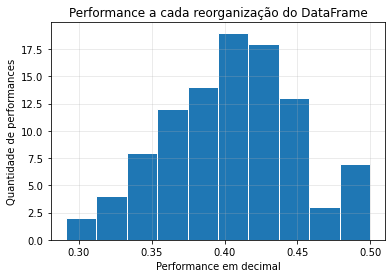

In [22]:
### Constrói histograma com os percentuais de acerto

from matplotlib import pyplot as plt

plt.hist(performances, edgecolor = 'white')
plt.ylabel('Quantidade de performances')
plt.xlabel('Performance em decimal')
plt.title('Performance a cada reorganização do DataFrame')
plt.grid(alpha=0.3)
plt.show()

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis
* CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

___
## Referências bibliográficas

[Examples for Portuguese Processing - nltk](http://www.nltk.org/howto/portuguese_en.html)

[STOP WORDS – COMO FUNCIONAM PALAVRAS DE PARADA?](https://www.agenciamestre.com/seo/stop-words-como-funcionam-palavras-de-parada/)

[APLICAÇÕES PRÁTICAS DE MINERAÇÃO DE DADOS E ALGORITMO DE NAIVE BAYES](https://www.webartigos.com/artigos/aplicacoes-praticas-de-mineracao-de-dados-e-algoritmo-de-naive-bayes/165614)